# Introduction

This tutorial will walk you through a preliminary similarity searching analysis making use of scripts in the AMOEBAE toolkit. While AMOEBAE was not originally written to be used via the command line, Jupyter notebooks provide an easy means of guiding new users through an example analysis with limited need for manual input. The end result of running this code successfully is a spreadsheet summarizing results of similarity searches, as well as a plot to visualize the results.

As a simple example, we will consider the the distribution of orthologues of subunits of the Adaptor Protein (AP) 2 vesicle adaptor complex, and several other membrane-trafficking proteins, in five model eukaryotes: the plant *Arabidopsis thaliana*, the yeast *Saccharomyces cerevisiae*, the fungus *Allomyces macrogynus*, the amoeba *Dictyostelium discoideum*, and the pathogenic protist *Trypanosoma brucei*. AP-2 subunits are homologous to subunits of other AP complexes (Robinson, 2004; Hirst et al., 2011), and published work has traced their evolution among plants (Larson et al., 2019), Fungi (Barlow et al., 2014), and trypanosomatid parasites (Manna et al., 2013). Thus, the protein subunits of the AP-2 complex provide a useful test of similarity searching methods to distinguish between orthologues and paralogues, which can be compared to the results of previous studies. In addition, the membrane trafficking proteins Sec12 (a component of the COPII vesicle coat complex), SNAP33 (a Qbc-SNARE), and Rab2 (a small GTPase) are included to further explore the potential sources of error involved in identification of orthologous proteins.

## Objectives of this tutorial


-  Perform similarity searches using the BLASTP, TBLASN, HMMer algorithms simultaneously using AMOBEAE scripts.

-  Apply a reciprocal-best-hit search strategy using AMOEBAE code.

- Practice interpreting similarity search results obtained using AMOEBAE.


## Requirements

- Before running this code, you will need to have set up AMOEBAE according to the instructions in the main documentation file here (which you likely have already done): [AMOEBAE_documentation.pdf](
https://github.com/laelbarlow/amoebae/blob/master/documentation/AMOEBAE_documentation.pdf).

- MacOS or Linux operating system (or possibly a work-around on windows, although this has not been tested).

- Approximately 3GB of storage space.

- An internet connection.

- At least an hour of your time (the code in this notebook will take approximately 60 minutes to run).

- Running the code in this notebook is more computationally intensive than webbrowsing for example, so if you are running this on a laptop computer, then make sure it is connected to an electrical outlet.

## Testing
If you wish to simply run all the code in this notebook for testing purposes:

- First, modify the cell in the section labeled "Enter your email to access the NCBI protein database via NCBI Entrez" below such that the value of Entrez.email is hard-coded as your email address.

- Then select "Cell" > "Run All" from the Jupyter menu above.

# Preliminary steps

## Check that dependencies are installed
You should have already pulled the amoebae git repository to your computer as described in the main documentation file.

In [1]:
%%bash
# This command simply prints the versions of some dependencies which are now available for use by amoebae.
amoebae check_depend



BLASTP version:
blastp: 2.9.0+


HMMer version:
# hmmsearch :: search profile(s) against a sequence database
# HMMER 3.3 (Nov 2019); http://hmmer.org/
# Copyright (C) 2019 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.


HMMer esl-fetch utilities:
# esl-sfetch :: retrieve sequence(s) from a file
# Easel 0.46 (Nov 2019)
# Copyright (C) 2019 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.


MUSCLE version:
MUSCLE v3.8.31 by Robert C. Edgar


IQ-TREE version:
IQ-TREE multicore version 1.6.12 for Linux 64-bit built Aug 15 2019




In [2]:
%%bash
# This command tests all the import statements in amoebae modules.
amoebae check_imports


Non-redundant list of import statements:

1. import sys  # add_seq_man.py
2. import os  # add_seq_man.py
3. import shutil  # add_seq_man.py
4. import time  # add_seq_man.py
5. from afa_to_nex import afa_to_nex, nex_to_afa  # add_seq_man.py
6. from afa_to_fa import afa_to_fa  # add_seq_man.py
7. from afa_to_nex import align_one_fa  # add_seq_man.py
8. from subprocess import call  # add_seq_man.py
9. from parse_mod_num import update_mod_num_numeric  # add_seq_man.py
10. import subprocess  # boots_on_best_ml.py
11. import glob  # boots_on_best_ml.py
12. import settings  # boots_on_best_ml.py
13. from name_replace import write_newick_tree_with_uncoded_names  # boots_on_best_ml.py
14. import re  # boots_on_mb.py
15. from ete3 import Tree  # boots_on_mb.py
16. from settings import raxmlname  # boots_on_mb.py
17. from boots_on_mb import reformat_combined_supports, combine_supports,\  # boots_on_mb.py
18. mbcontre_to_newick_w_probs, contre_to_newick  # boots_on_mb.py
19. import math  # calcul

## Import some basic python modules

In [3]:
import os
import sys
import platform
import subprocess
from Bio import SeqIO
from Bio import Entrez
import glob
from Bio.Blast import NCBIXML
import pandas as pd
from IPython.display import display, HTML, Image

## Update PATH so that additional modules can be imported.

In [4]:
# Add parent directory (the main amoebae repository directory) to the $PATH.
sys.path.append('..')
!echo $PATH

/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin:/opt/ncbi-blast-2.9.0+/bin:/opt/iqtree-1.6.12-Linux/bin:/opt/:/home/vagrant/amoebae


In [5]:
import settings

## Record the specific version of AMOEBAE code used

In [6]:
# Record git repository version information.
wd = !pwd
script_dir = wd[0] 
git_hash = str(subprocess.check_output(["git", "rev-parse", "HEAD"], cwd=script_dir).strip())
git_branch = str(subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"], cwd=script_dir).strip())  
print('\nGit repository (code) version: ' + git_hash + ' (branch name: ' + git_branch + ')\n')


Git repository (code) version: b'0488feb36fd70f0abc6f328c5587eb89faeae703' (branch name: b'master')



## Make a subdirectory to store output.

In [7]:
%%bash
mkdir amoebae_tutorial_2_output

In [8]:
%cd amoebae_tutorial_2_output

/home/vagrant/amoebae/notebooks/amoebae_tutorial_2_output


# Set up sequence databases for searching

## Download peptide and nucleotide sequences for specific genomes.

Let's download the predicted peptide sequences, genomic assembly (nucleotide
sequences of assembled chromosomes), and annotation files (in GFF3 format) for the following eukaryotes from NCBI:

- *Arabidopsis thaliana*
- *Trypanosoma brucei*
- *Dictyostelium discoideum*
- *Allomyces macrogynus*
- *Saccharomyces cerevisiae*


This will take approximately 2 minutes.

In [9]:
%%time

# Initiate a list of file paths for downloaded sequence and annotation files.
datafile_path_list = []

# Define a dictionary of source URLs and new filenames for sequence and annotation files.
# Note that the filenames (besides extension) are the species name with underscores instead of spaces.
datafile_dict = {"Arabidopsis_thaliana.faa": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/735/GCF_000001735.4_TAIR10.1/GCF_000001735.4_TAIR10.1_protein.faa.gz",
                 "Arabidopsis_thaliana.fna": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/735/GCF_000001735.4_TAIR10.1/GCF_000001735.4_TAIR10.1_genomic.fna.gz",
                 "Arabidopsis_thaliana.gff3": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/735/GCF_000001735.4_TAIR10.1/GCF_000001735.4_TAIR10.1_genomic.gff.gz",
                 "Saccharomyces_cerevisiae.faa": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_protein.faa.gz",
                 "Saccharomyces_cerevisiae.fna": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz",
                 "Saccharomyces_cerevisiae.gff3": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.gff.gz",
                 "Trypanosoma_brucei.faa": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/295/GCF_000210295.1_ASM21029v1/GCF_000210295.1_ASM21029v1_protein.faa.gz",
                 "Trypanosoma_brucei.fna": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/295/GCF_000210295.1_ASM21029v1/GCF_000210295.1_ASM21029v1_genomic.fna.gz",
                 "Trypanosoma_brucei.gff3": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/295/GCF_000210295.1_ASM21029v1/GCF_000210295.1_ASM21029v1_genomic.gff.gz",
                 "Dictyostelium_discoideum.faa": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/004/695/GCF_000004695.1_dicty_2.7/GCF_000004695.1_dicty_2.7_protein.faa.gz",
                 "Dictyostelium_discoideum.fna": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/004/695/GCF_000004695.1_dicty_2.7/GCF_000004695.1_dicty_2.7_genomic.fna.gz",
                 "Dictyostelium_discoideum.gff3": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/004/695/GCF_000004695.1_dicty_2.7/GCF_000004695.1_dicty_2.7_genomic.gff.gz",
                 "Allomyces_macrogynus.faa": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/151/295/GCA_000151295.1_A_macrogynus_V3/GCA_000151295.1_A_macrogynus_V3_protein.faa.gz",
                 "Allomyces_macrogynus.fna": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/151/295/GCA_000151295.1_A_macrogynus_V3/GCA_000151295.1_A_macrogynus_V3_genomic.fna.gz",
                 "Allomyces_macrogynus.gff3": "ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/151/295/GCA_000151295.1_A_macrogynus_V3/GCA_000151295.1_A_macrogynus_V3_genomic.gff.gz"
          }

# Make a new temporary directory to store data files.
temp_db_dir_name = 'temporary_db_dir'
if not os.path.isdir(temp_db_dir_name):
    os.mkdir(temp_db_dir_name)

# Download all the data files via NCBI's FTP server.
for filename in datafile_dict.keys():
    url = datafile_dict[filename]
    filepath = os.path.join(temp_db_dir_name, filename)
    if not os.path.isfile(filepath):
        subprocess.call(['curl', url, '--output', filepath + '.gz'])
        subprocess.call(['gunzip', filepath + '.gz'])

CPU times: user 27.2 ms, sys: 39.6 ms, total: 66.8 ms
Wall time: 1min 19s


## Initiate a data directory structure
To generate a directory structure and spreadsheets for storing formatted sequence files
and metadata for each sequence file, use the 'mkdatadir' command (this takes a
single argument which is the full path that you want your new directory to be
written to):

In [10]:
%env DATADIR=AMOEBAE_Data

env: DATADIR=AMOEBAE_Data


In [11]:
%%bash
amoebae mkdatadir $DATADIR


        
        To allow AMOEBAE scripts to locate your new data directory, change the
        value of the root_amoebae_data_dir variable in the settings.py file to
        the full path to the directory:

        AMOEBAE_Data
        


This will prompt you to set the 'root\_amoebae\_data\_dir' variable in the
settings.py file to this new directory path so that AMOEBAE scripts can locate
your files.

This can be done as follows:

In [12]:
# Check that the path indicated in the settings file is correct.
import settings
print(settings.root_amoebae_data_dir)
assert settings.root_amoebae_data_dir == "AMOEBAE_Data"

AMOEBAE_Data


## Prepare databases for searching
To generate a directory structure and spreadsheets for storing formatted sequence files
and metadata for each sequence file, use the 'mkdatadir' command (this takes a
single argument which is the full path that you want your new directory to be
written to).

This will take at least 11 minutes, because the FASTA files need to be re-written with re-formatted sequence headers and the GFF3 files need to be converted to SQL databases using gffutils.

In [13]:
%%bash
SECONDS=0

for X in temporary_db_dir/*; do amoebae add_to_dbs $X; done

ELAPSED="Preparing sequence databases for searching took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED



Building a new DB, current time: 04/12/2020 04:18:31
New DB name:   /home/vagrant/amoebae/notebooks/amoebae_tutorial_2_output/AMOEBAE_Data/Genomes/Allomyces_macrogynus.faa
New DB title:  AMOEBAE_Data/Genomes/Allomyces_macrogynus.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 19447 sequences in 0.787349 seconds.
Creating SSI index for AMOEBAE_Data/Genomes/Allomyces_macrogynus.faa...    done.
Indexed 19447 sequences (19447 names).
SSI index written to file AMOEBAE_Data/Genomes/Allomyces_macrogynus.faa.ssi


Building a new DB, current time: 04/12/2020 04:18:33
New DB name:   /home/vagrant/amoebae/notebooks/amoebae_tutorial_2_output/AMOEBAE_Data/Genomes/Allomyces_macrogynus.fna
New DB title:  AMOEBAE_Data/Genomes/Allomyces_macrogynus.fna
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 101 sequences in 1.02407 seconds.
Creating SSI index for AMOEBAE_Data/Genomes/Allomyces_

In [14]:
%%bash
# List the databases now accessible by AMOEBAE.
amoebae list_dbs

Allomyces_macrogynus.faa
Allomyces_macrogynus.fna
Arabidopsis_thaliana.faa
Arabidopsis_thaliana.fna
Dictyostelium_discoideum.faa
Dictyostelium_discoideum.fna
Saccharomyces_cerevisiae.faa
Saccharomyces_cerevisiae.fna
Trypanosoma_brucei.faa
Trypanosoma_brucei.fna


After adding each file to the AMOEBAE_Data directory, a line is added to the 0_genome_info.csv file with information describing this file. Information from this CSV file is used in downstream analysis steps, so it is important to ensure that it is accurate. 

You can view the contents of this CSV file here (empty fields are displayed as "NaN"):

In [15]:
# Find the path to the CSV file.
csv_file_path = os.path.join(os.path.join(os.environ['DATADIR'], 'Genomes'), '0_genome_info.csv')
# Load data from the CSV file using the pandas library.
df = pd.read_csv(csv_file_path)
# Display the data in an HTML table.
print("Contents of the file %s:" % csv_file_path)
display(HTML(df.to_html()))

Contents of the file AMOEBAE_Data/Genomes/0_genome_info.csv:


,Filename,Superbranch,Supergroup,Group,Species (if applicable),Taxon,Strain,Data type,Assembly,Source,Date,Citation,Note,?,Annotations file
0,Allomyces_macrogynus.faa,NaN,NaN,NaN,Allomyces macrogynus,NaN,NaN,prot,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
1,Allomyces_macrogynus.fna,NaN,NaN,NaN,Allomyces macrogynus,NaN,NaN,nucl,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
2,Allomyces_macrogynus.sql,NaN,NaN,NaN,Allomyces macrogynus,NaN,NaN,annotations,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
3,Arabidopsis_thaliana.faa,NaN,NaN,NaN,Arabidopsis thaliana,NaN,NaN,prot,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
4,Arabidopsis_thaliana.fna,NaN,NaN,NaN,Arabidopsis thaliana,NaN,NaN,nucl,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
5,Arabidopsis_thaliana.sql,NaN,NaN,NaN,Arabidopsis thaliana,NaN,NaN,annotations,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
6,Dictyostelium_discoideum.faa,NaN,NaN,NaN,Dictyostelium discoideum,NaN,NaN,prot,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
7,Dictyostelium_discoideum.fna,NaN,NaN,NaN,Dictyostelium discoideum,NaN,NaN,nucl,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
8,Dictyostelium_discoideum.sql,NaN,NaN,NaN,Dictyostelium discoideum,NaN,NaN,annotations,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN
9,Saccharomyces_cerevisiae.faa,NaN,NaN,NaN,Saccharomyces cerevisiae,NaN,NaN,prot,NaN,NaN,2020/04/12,NaN,NaN,NaN,NaN


I recommended that you add any relevant information to complete this table, although this is not necessary to complete this tutorial. This can serve as a useful record for your own reference, as well as as a supplementary file in publications.

By default, AMOEBAE assumes that GFF3 annotation files will be given the same filename (besides the extension) as the nucleotide FASTA file containing the sequences that the annotations are for. For example, to retrieve annotations for assembled chromosome sequences in a file named "Arabidopsis_thaliana.fna", AMOEBAE will look for a file named "Arabidopsis_thaliana.sql" (which is generated using a file with the name "Arabidopsis_thaliana.gff3). If you wish to use different annotation files, open the CSV file in a spreadsheet program such as Excel or Open Office then copy the name of the .sql file to the row for the corresponding genomic assembly (.fna) file in the column with the header "Annotations file", and do the same for the row describing the corresponding peptide sequence (.faa) file. This allows the correct GFF3 file to be used for the assembly (.fna file) and predicted amino acid sequences (.faa).

Taxonomic information for each genome is arbitrarily divided into four hierarchical categories: "Superbranch", "Supergroup", "Group", and "Species (if applicable)". For files containing sequences or annotations for *Arabidopsis thaliana*, I would enter the values "Diaphoretickes", "Archaeplastida", "Embryophyta", and "Arabidopsis thaliana", respectively. These are arbitrary selected taxonomic groups to which Arabidopsis belongs (Adl et al., 2018). This can be useful when you have many genomes represented in the table.

# Set up queries

## Enter your email to access the NCBI protein database via NCBI Entrez

In [16]:
# Comment out this line and use the line at the bottom of this cell instead, if you want to run all cells at once.
#Entrez.email = input("Enter your email address here: ")  # Tell NCBI who you are.

# Use the line at the top of this cell instead.
#Entrez.email = "yourname@email.com"
Entrez.email = "lael@ualberta.ca"

## Download single-sequence queries

In [17]:
%%time

# Define a dictionary with NCBI sequence accessions as keys and filenames to write
# the corresponding sequences to as values.
query_dict = {"NP_194077.1": "AP1beta_Athaliana_NP_194077.1_query.faa",
              "NP_851058.1": "AP2alpha_Athaliana_NP_851058.1_query.faa",
              "NP_974895.1": "AP2mu_Athaliana_NP_974895.1_query.faa",
              "NP_175219.1": "AP2sigma_Athaliana_NP_175219.1_query.faa",
              "NP_566961.1": "Sec12_Athaliana_NP_566961.1_query.faa",
              "NP_200929.1": "SNAP33_Athaliana_NP_200929.1_query.faa",
              "NP_193449.1": "Rab2_Athaliana_NP_193449.1_query.faa"
          }

# Make a new temporary directory to store sequence files.
temp_query_dir_name = 'temporary_query_dir'
if not os.path.isdir(temp_query_dir_name):
    os.mkdir(temp_query_dir_name)

# Loop over keys in the query_dict dictionary.
for accession in query_dict.keys():
    # Retrieve the corresponding filename from the dictionary.
    filename = query_dict[accession]
    filepath = os.path.join(temp_query_dir_name, filename)
    # Only download sequences that have not already been downloaded.
    if not os.path.isfile(filepath):
        # Download the sequence from NCBI via Entrez, using the Biopython module.
        net_handle = Entrez.efetch(db="protein", id=accession, rettype="fasta", retmode="text")
        out_handle = open(filepath, "w")
        out_handle.write(net_handle.read())
        out_handle.close()
        net_handle.close()
    # Check that the sequence was actually downloaded.
    assert os.path.isfile(filepath), """The sequence with the following accession could not be downloaded from NCBI: %s\n
    Try re-running this cell.""" % accession

CPU times: user 72.5 ms, sys: 29.4 ms, total: 102 ms
Wall time: 3.83 s


## Prepare single-sequence queries for searching

Queries must be formatted and stored in a similar manner to genomic data files. The query files will include FASTA files containing one sequence and FASTA files containing multiple sequences.
Now we are going to generate the query files and add them to your AMOEBAE_Data/ Queries directory, in a similar way to how we added genomic data files to the AMOEBAE_Data/Genomes directory. Since you already downloaded all the peptide sequences for Arabidopsis thaliana, you can retrieve these from your downloaded data using one of the scripts in the amoebae/misc_scripts folder. First, let’s generate a query for the A. thaliana AP-1/2 beta subunit(s), which is a component of both the AP-1 and AP-2 complexes, using a representative sequence:

In [18]:
%%bash
SECONDS=0

for QUERYFILE in temporary_query_dir/*.faa; do amoebae add_to_queries $QUERYFILE; done

ELAPSED="Preparing query sequences for searching took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED

Preparing query sequences for searching took the following amount of time: 0hrs 0min 4sec


In [19]:
%%bash
amoebae list_queries

AP1beta_Athaliana_NP_194077.1_query.faa
AP2alpha_Athaliana_NP_851058.1_query.faa
AP2mu_Athaliana_NP_974895.1_query.faa
AP2sigma_Athaliana_NP_175219.1_query.faa
Rab2_Athaliana_NP_193449.1_query.faa
SNAP33_Athaliana_NP_200929.1_query.faa
Sec12_Athaliana_NP_566961.1_query.faa


## Construct alignments for profile similarity searching

In [20]:
%%time

# Define a dictionary of NCBI sequence accessions and filenames to which to write the corresponding sequences.
query_title_dict = {"AP1beta": "NP_194077.1,CBI34366.3,XP_015631818.1,XP_024516549.1,OAE33273.1",
                    "AP2alpha": "NP_851058.1,XP_002270388.1,XP_015631820.1,PTQ35247.1,XP_024525508.1",
                    "AP2mu": "NP_974895.1,XP_002281297.1,XP_015627628.1,OAE25965.1,XP_002973295.1",
                    "AP2sigma": "NP_175219.1,XP_015618362.1,PTQ50284.1,XP_002275803.1,XP_024518676.1",
                    "Sec12": "NP_566961.1,XP_002262948.1,XP_015647566.1,OAE21792.1,XP_024530559.1",
                    "SNAP33": "NP_200929.1,XP_002284486.1,AAW82752.1,EFJ31467.1,OAE29824.1,XP_006270633.1,XP_006010378.1,XP_006625751.1,NP_001080510.1,XP_020370357.1,XP_015181699.1,XP_031769811.1",
                    "Rab2": "NP_193449.1,XP_003635585.2,XP_015626284.1,XP_002965710.1,PTQ28228.1"
                   }
                    

# Make a new temporary directory to store sequence files.
temp_alignment_dir_name = 'temporary_alignment_dir'
assert not os.path.isdir(temp_alignment_dir_name), """Directory already exists."""
os.mkdir(temp_alignment_dir_name)

# Download query sequences and write to multiple-sequence FASTA files.
for query_title in query_title_dict.keys():
    accession_list_string = query_title_dict[query_title]
    filepath = os.path.join(temp_alignment_dir_name, query_title + '_hmm1.faa')
    if not os.path.isfile(filepath):
        net_handle = Entrez.efetch(db="protein", id=accession_list_string, rettype="fasta", retmode="text")
        out_handle = open(filepath, "w")
        out_handle.write(net_handle.read())
        out_handle.close()
        net_handle.close()

CPU times: user 90.3 ms, sys: 8.63 ms, total: 99 ms
Wall time: 7.93 s


In [21]:
%%bash
SECONDS=0

for X in temporary_alignment_dir/*.faa; do amoebae align_fa $X --output_format fasta; done

ELAPSED="Aligning FASTA files took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED

Aligning FASTA files took the following amount of time: 0hrs 0min 4sec



MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

AP1beta_hmm1 5 seqs, max length 920, avg  length 901
00:00:00     10 MB(1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00     10 MB(1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00     16 MB(2%)  Iter   1  100.00%  Align node
00:00:00     16 MB(2%)  Iter   1  100.00%  Root alignment
00:00:00     16 MB(2%)  Iter   2  100.00%  Refine tree
00:00:00     16 MB(2%)  Iter   2  100.00%  Root alignment
00:00:00     16 MB(2%)  Iter   2  100.00%  Root alignment
00:00:00     16 MB(2%)  Iter   3  100.00%  Refine biparts
00:00:00     16 MB(2%)  Iter   4  100.00%  Refine biparts
00:00:00     16 MB(2%)  Iter   5  100.00%  Refine biparts
00:00:00     16 MB(2%)  Iter   6  100.00%  Refine biparts
00:00:00     16 MB(2%)  Iter   7  100.00%  Refine biparts
00:00:00     16 MB(2%)  Iter   8  100.00%  Refine biparts
00:00:00     16 MB(2%)

Similar to the AMOEBAE_Data/Genomes/0_genome_info.csv file, the AMOEBAE_Data/Queries/0_query_info.csv file contains information about each query file, which can be manually edited. One of the most important pieces of information is the "Query title". Different query files, such as a single FASTA sequence and an HMM, can have the same Query title if they are to be used to search for homologues or orthologues of the same protein(s).

In [22]:
# Find the path to the CSV file.
csv_file_path = os.path.join(os.path.join(os.environ['DATADIR'], 'Queries'), '0_query_info.csv')
# Load data from the CSV file using the pandas library.
df = pd.read_csv(csv_file_path)
# Display the data in an HTML table.
print("Contents of the file %s:" % csv_file_path)
display(HTML(df.to_html()))

Contents of the file AMOEBAE_Data/Queries/0_query_info.csv:


,Filename,Query title,Query source description,Query taxon (species if applicable),Query database filename (if applicable),File type,Data type,Date added,Citation
0,AP1beta_Athaliana_NP_194077.1_query.faa,AP1beta,Athaliana,-,-,faa,prot,2020/04/12,?
1,AP2alpha_Athaliana_NP_851058.1_query.faa,AP2alpha,Athaliana,-,-,faa,prot,2020/04/12,?
2,AP2mu_Athaliana_NP_974895.1_query.faa,AP2mu,Athaliana,-,-,faa,prot,2020/04/12,?
3,AP2sigma_Athaliana_NP_175219.1_query.faa,AP2sigma,Athaliana,-,-,faa,prot,2020/04/12,?
4,Rab2_Athaliana_NP_193449.1_query.faa,Rab2,Athaliana,-,-,faa,prot,2020/04/12,?
5,SNAP33_Athaliana_NP_200929.1_query.faa,SNAP33,Athaliana,-,-,faa,prot,2020/04/12,?
6,Sec12_Athaliana_NP_566961.1_query.faa,Sec12,Athaliana,-,-,faa,prot,2020/04/12,?


## Visually inspect alignments
Alignments used as queries should be visually inspected to make sure that there are no obvious errors in the alignment.

In [23]:
%%bash
for QUERYFILE in temporary_alignment_dir/*.afaa; do amoebae afa_to_nex $QUERYFILE; done
echo "Alignments to observe:"
ls temporary_alignment_dir/*.nex

Alignments to observe:
temporary_alignment_dir/AP1beta_hmm1.nex
temporary_alignment_dir/AP2alpha_hmm1.nex
temporary_alignment_dir/AP2mu_hmm1.nex
temporary_alignment_dir/AP2sigma_hmm1.nex
temporary_alignment_dir/Rab2_hmm1.nex
temporary_alignment_dir/SNAP33_hmm1.nex
temporary_alignment_dir/Sec12_hmm1.nex


## Prepare query alignments for searching

In [24]:
%%bash
SECONDS=0

for QUERYFILE in temporary_alignment_dir/*.afaa; do amoebae add_to_queries $QUERYFILE; done

ELAPSED="Preparing HMM queries from alignments took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3 (Nov 2019); http://hmmer.org/
# Copyright (C) 2019 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             AMOEBAE_Data/Queries/AP1beta_hmm1_temp1.afa
# output HMM file:                  AMOEBAE_Data/Queries/AP1beta_hmm1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     AP1beta_hmm1_temp1       5   935   899     0.46  0.595 

# CPU time: 0.68u 0.01s 00:00:00.69 Elapsed: 00:00:00.70
# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3 (Nov 2019); http://hmmer.org/
# Copyright (C) 2019 Howard Hughes Medical Institute.
# Freely distributed under the BSD op

List queries

In [25]:
%%bash
amoebae list_queries

AP1beta_Athaliana_NP_194077.1_query.faa
AP1beta_hmm1.afaa
AP2alpha_Athaliana_NP_851058.1_query.faa
AP2alpha_hmm1.afaa
AP2mu_Athaliana_NP_974895.1_query.faa
AP2mu_hmm1.afaa
AP2sigma_Athaliana_NP_175219.1_query.faa
AP2sigma_hmm1.afaa
Rab2_Athaliana_NP_193449.1_query.faa
Rab2_hmm1.afaa
SNAP33_Athaliana_NP_200929.1_query.faa
SNAP33_hmm1.afaa
Sec12_Athaliana_NP_566961.1_query.faa
Sec12_hmm1.afaa


## Generate lists of potential redundant sequences among *A. thaliana* peptide sequences

In this tutorial, a reciprocal-best-hit search strategy will be used. If you are using a reciprocal- best-hit search strategy, then your initial round of searches will be performed using your original queries (assembled above) to search your genomes of interest. This initial round of searches will be referred to herein as "forward searches", and subsequent searches using forward search hits as queries into reference genomes will be referred to as "reverse searches".

A slight complication to this search strategy is that the NCBI RefSeq peptide sequences for the *A. thaliana* genome include alternative transcripts and lineage-specific inparalogues (as do other databases), implying that if these were retrieved as the top hits in the reverse searches instead of the original query sequence, then this would still potentially be a positive result. So, to properly interpret reverse search results it will be necessary to determine which sequences in our A. thaliana.faa file are redundant for our purposes. To do this we will use the get_redun_hits command:

In [26]:
%%bash
# Optional. Get the help output for the get_redun_hits command.
amoebae get_redun_hits -h

usage: amoebae [-h] [--csv_file CSV_FILE] [--query_name QUERY_NAME]
               [--query_list_file QUERY_LIST_FILE] [--db_name DB_NAME]
               [--db_list_file DB_LIST_FILE] [--query_title QUERY_TITLE]
               [--outdir OUTDIR]
               [--blast_report_evalue_cutoff BLAST_REPORT_EVALUE_CUTOFF]
               [--blast_max_target_seqs BLAST_MAX_TARGET_SEQS]
               [--hmmer_report_evalue_cutoff HMMER_REPORT_EVALUE_CUTOFF]
               [--hmmer_report_score_cutoff HMMER_REPORT_SCORE_CUTOFF]
               [--num_threads_similarity_searching NUM_THREADS_SIMILARITY_SEARCHING]
               srch_dir

Run searches with queries to find redundant hits in databases (for
interpreting results).

positional arguments:
  srch_dir              Path to directory that will contain output directory
                        as a subdirectory.

optional arguments:
  -h, --help            show this help message and exit
  --csv_file CSV_FILE   Path to spreadsheet to append s

In [27]:
%env REDUNHITDIR=Redundant_hits

env: REDUNHITDIR=Redundant_hits


This step will take approximately 5 minutes:

In [28]:
%%bash
SECONDS=0

# Make a directory to store information about redundant hits.
mkdir $REDUNHITDIR

# Write a file listing names of query files to be used.
amoebae list_queries > $REDUNHITDIR/queries.txt

# Use AMOEBAE to retrieve potential redundant hit sequences.
amoebae get_redun_hits $REDUNHITDIR --query_list_file $REDUNHITDIR/queries.txt --db_name Arabidopsis_thaliana.faa

ELAPSED="Retrieving potentially redundant sequences took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED

DONE!


Edit spreadsheet to classify hits as redundant or not before
        proceeding (modify values in the 'Positive/redundant (+) or negative
        (-) hit for queries with query title' column):

	Redundant_hits/redun_hits_20200412042531/0_redun_hits_20200412042531.csv

Retrieving potentially redundant sequences took the following amount of time: 0hrs 3min 15sec


This will output a directory in the Redundant_hits folder with a .csv file. This file contains a summary of BLASTP or HMMer search results for searches with the specified queries into the *A. thaliana* predicted proteins. 

It should be apparent upon inspection of the ranking of hits and comparison of the associated E-values which hits are likely redundant with your queries (see cell below). To tell AMOEBAE which hits you want to consider as redundant for the purposes of downstream steps, the values in the column with the header "Positive/redundant (+) or negative (-) hit for queries with query title (edit this column)" must be changed from ’-’ to ’+’ for hits that are redundant (this will be done automatically for this tutorial (see below).

In [29]:
# Find the path to the CSV file.
csv_file_path = glob.glob(os.path.join('Redundant_hits', os.path.join('redun_hits_*', '0_redun_hits_*.csv')))[0]
# Load data from the CSV file using the pandas library.
df = pd.read_csv(csv_file_path)
# Display the data in an HTML table.
print("Contents of the file %s:" % csv_file_path)
display(HTML(df.to_html()))

Contents of the file Redundant_hits/redun_hits_20200412042531/0_redun_hits_20200412042531.csv:


,Query Title,Query File,Database File,Search Method,Positive/redundant (+) or negative (-) hit for queries with query title (edit this column),Hit Number,E-value,Order of magnitude of E-value difference compared to top hit,Length as percent of top hit sequence length,Accession,Description,Unnamed: 11
0,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,1,0.000000e+00,0,100,NP_194077.1,NP_194077.1 Adaptin family protein [Arabidopsis thaliana],NaN
1,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,2,0.000000e+00,0,100,NP_192877.1,NP_192877.1 Adaptin family protein [Arabidopsis thaliana],NaN
2,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,3,0.000000e+00,0,89,NP_001328014.1,NP_001328014.1 Adaptin family protein [Arabidopsis thaliana],NaN
3,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,4,0.000000e+00,0,103,NP_001190701.1,NP_001190701.1 Adaptin family protein [Arabidopsis thaliana],NaN
4,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,5,2.418810e-110,190,94,NP_196710.1,NP_196710.1 adaptin family protein [Arabidopsis thaliana],NaN
5,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,6,3.470670e-110,191,95,NP_001190290.1,NP_001190290.1 adaptin family protein [Arabidopsis thaliana],NaN
6,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,7,1.576930e-105,195,89,NP_001330519.1,NP_001330519.1 adaptin family protein [Arabidopsis thaliana],NaN
7,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,8,6.586930e-30,271,125,NP_974443.4,NP_974443.4 protein affected trafficking 2 [Arabidopsis thaliana],NaN
8,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,9,2.023720e-22,278,111,NP_567022.1,NP_567022.1 protein affected trafficking 2 [Arabidopsis thaliana],NaN
9,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,10,1.004840e-10,290,109,NP_001328341.1,"NP_001328341.1 Coatomer, beta subunit [Arabidopsis thaliana]",NaN


## Identify redundant sequences

In [30]:
%time
# Define a dictionary with query titles as keys and lists of sequence IDs as values, where the IDs are for A. thaliana sequences that are redundant with the original A. thaliana query sequence.
redun_seq_dict = {"AP1beta":  ["NP_194077.1",
                               "NP_192877.1",
                               "NP_001328014.1",
                               "NP_001190701.1"
                               ],
                  
                  "AP2alpha": ["NP_851058.1",
                               "NP_851057.1",
                               "NP_197669.1",
                               "NP_001330971.1",
                               "NP_001330970.1",
                               "NP_001330969.1",
                               "NP_197670.1",
                               "NP_001330127.1"
                               ],
                  
                  "AP2mu":    ["NP_974895.1",
                               "NP_199475.1"
                               ],
                  
                  "AP2sigma": ["NP_175219.1"
                               ],
                  
                  "Sec12":    ["NP_566961.1",
                               "NP_568738.1",
                               "NP_680414.1",
                               "NP_178256.1"
                               ],
                  
                  "SNAP33":   ["NP_200929.1",
                               "NP_001332102.1",
                               "NP_172842.1",
                               "NP_001318998.1",
                               "NP_196405.1",
                               "NP_001318503.1"
                               ],
                  
                  "Rab2":     ["NP_193449.1",
                               "NP_193450.1",
                               "NP_195311.1",
                               "NP_001078499.1"
                               ]
                   }


# Identify path to redundant seqs CSV file.
redundant_seqs_csv = glob.glob(os.path.join('Redundant_hits', os.path.join('redun_hits_*', '0_redun_hits_*.csv')))[0]

# Define path for new modified redundant seqs CSV file.
redundant_seqs_csv2 = redundant_seqs_csv.rsplit(".", 1)[0] + '_2.csv'

# Open the redundant seqs CSV file, and a new one.
with open(redundant_seqs_csv) as infh, open(redundant_seqs_csv2, 'w') as o:
    # Loop over lines in the CSV file.
    for i in infh:
        if not i.startswith("Query Title"):
            # Identify query title in line.
            line_query_title = i.split(',')[0].strip()
            # Identify accession/id for sequence hit represented in this row.
            line_accession = i.split(',')[9].strip().strip('\"')
            # Loop over keys (query titles) in the redundant seqs dictionary.
            query_title_in_keys = False
            for query_title in redun_seq_dict.keys():
                if line_query_title == query_title:
                    query_title_in_keys = True
                    #print('YYY')
                    #print(line_accession)
                    #print(redun_seq_dict[line_query_title])
                    # Determine whether the accession is a redundant accession.
                    for acc in redun_seq_dict[line_query_title]:
                        #print(line_accession, acc)
                        if line_accession == acc:
                            # Change the - to + so that the accession will be included in the list of redundant accessions used by AMOEBAE.
                            i = ','.join(i.split(',')[:4]) + ',+,' + ','.join(i.split(',')[5:])
                            break
                # Break loop if the corresponding query title was found already.
                if query_title_in_keys:
                    break
            # Check that a query title could be recognized as one that is a key in the dictionary.
            assert query_title_in_keys, """Could not find query title %s in dictionary.""" % line_query_title
        # Write (modified) line to new CSV file.
        o.write(i)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


Observe how the file has been modified.

In [31]:
# Find the path to the CSV file.
csv_file_path = glob.glob(os.path.join('Redundant_hits', os.path.join('redun_hits_*', '0_redun_hits_*2.csv')))[0]
# Load data from the CSV file using the pandas library.
df = pd.read_csv(csv_file_path)
# Display the data in an HTML table.
print("Contents of the file %s:" % csv_file_path)
display(HTML(df.to_html()))

Contents of the file Redundant_hits/redun_hits_20200412042531/0_redun_hits_20200412042531_2.csv:


,Query Title,Query File,Database File,Search Method,Positive/redundant (+) or negative (-) hit for queries with query title (edit this column),Hit Number,E-value,Order of magnitude of E-value difference compared to top hit,Length as percent of top hit sequence length,Accession,Description,Unnamed: 11
0,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,+,1,0.000000e+00,0,100,NP_194077.1,NP_194077.1 Adaptin family protein [Arabidopsis thaliana],NaN
1,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,+,2,0.000000e+00,0,100,NP_192877.1,NP_192877.1 Adaptin family protein [Arabidopsis thaliana],NaN
2,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,+,3,0.000000e+00,0,89,NP_001328014.1,NP_001328014.1 Adaptin family protein [Arabidopsis thaliana],NaN
3,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,+,4,0.000000e+00,0,103,NP_001190701.1,NP_001190701.1 Adaptin family protein [Arabidopsis thaliana],NaN
4,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,5,2.418810e-110,190,94,NP_196710.1,NP_196710.1 adaptin family protein [Arabidopsis thaliana],NaN
5,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,6,3.470670e-110,191,95,NP_001190290.1,NP_001190290.1 adaptin family protein [Arabidopsis thaliana],NaN
6,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,7,1.576930e-105,195,89,NP_001330519.1,NP_001330519.1 adaptin family protein [Arabidopsis thaliana],NaN
7,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,8,6.586930e-30,271,125,NP_974443.4,NP_974443.4 protein affected trafficking 2 [Arabidopsis thaliana],NaN
8,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,9,2.023720e-22,278,111,NP_567022.1,NP_567022.1 protein affected trafficking 2 [Arabidopsis thaliana],NaN
9,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,Arabidopsis_thaliana.faa,blastp 2.9.0+,-,10,1.004840e-10,290,109,NP_001328341.1,"NP_001328341.1 Coatomer, beta subunit [Arabidopsis thaliana]",NaN


# Run forward searches

To begin searching, make a new folder to contain search results, and write text files listing the names (not full paths) of FASTA files you want to use as queries and those that you want to search in.

In [32]:
%env SRCHRESDIR=AMOEBAE_Search_Results_1

env: SRCHRESDIR=AMOEBAE_Search_Results_1


In [33]:
%%bash
# Make a new directory to contain search results.
mkdir $SRCHRESDIR
# Write query and database list files.
amoebae list_queries > $SRCHRESDIR/queries.txt
amoebae list_dbs > $SRCHRESDIR/databases.txt

Set up searches using the setup_fwd_srch command:

In [34]:
%%bash
# Optional. Get the help output for the setup_fwd_srch command.
amoebae setup_fwd_srch -h

usage: amoebae [-h] [--outdir OUTDIR] srch_dir query_list_file db_list_file

Make a directory in which to write output files from similarity searches.

positional arguments:
  srch_dir         Path to directory that will contain output directory as a
                   subdirectory.
  query_list_file  Path to file with list of queries to search with.
  db_list_file     Path to file with list of databases to search with.

optional arguments:
  -h, --help       show this help message and exit
  --outdir OUTDIR  Path to directory to put search results into (so that this
                   step can be piped together with other commands). (default:
                   None)

Note: Use the bash script to run forward searches on a remote server.


In [35]:
%env FWDSRCHDIR=fwd_srch_1

env: FWDSRCHDIR=fwd_srch_1


In [36]:
%%bash
# Set up forward searches.
amoebae setup_fwd_srch $SRCHRESDIR\
                       $SRCHRESDIR/queries.txt\
                       $SRCHRESDIR/databases.txt\
                       --outdir $SRCHRESDIR/$FWDSRCHDIR

This will output a new sub-directory with a name that starts with "fwd_srch_". Now run the searches with this directory as input via the run_fwd_srch command. Forward search criteria may be selected at this point (view the relevant optional arguments via the -h option).

In [37]:
%%bash
tree $SRCHRESDIR

AMOEBAE_Search_Results_1
|-- 0_amoebae_log.txt
|-- databases.txt
|-- fwd_srch_1
|   |-- 0_databases.txt
|   |-- 0_queries.txt
|   `-- 0_run_searches.sh
`-- queries.txt

1 directory, 6 files


In [38]:
%%bash
SECONDS=0

# Run forward searches. This could take a while.
amoebae run_fwd_srch $SRCHRESDIR/$FWDSRCHDIR

ELAPSED="Running forward searches took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED


                    in nucleotide data Allomyces_macrogynus.fna



                    in nucleotide data Arabidopsis_thaliana.fna



                    in nucleotide data Dictyostelium_discoideum.fna



                    in nucleotide data Saccharomyces_cerevisiae.fna



                    in nucleotide data Trypanosoma_brucei.fna



                    in nucleotide data Allomyces_macrogynus.fna



                    in nucleotide data Arabidopsis_thaliana.fna



                    in nucleotide data Dictyostelium_discoideum.fna



                    in nucleotide data Saccharomyces_cerevisiae.fna



                    in nucleotide data Trypanosoma_brucei.fna



                    in nucleotide data Allomyces_macrogynus.fna



                    in nucleotide data Arabidopsis_thaliana.fna



                    in nucleotide data Dictyostelium_discoideum.fna



                    in nucleotide data Saccharomyces_cerevisiae.fna



                    in nucleotide data Tr

This will run BLASTP or HMMer for searches into the .faa files (depending on whether queries are single- or multi-fasta), or TBLASTN for searches into the .fna files with any single-fasta queries.

# Summarize forward search results

Now we can generate a summary of the raw output files. Important criteria may be customized here as well. Specifically the forward search E-value threshold, and the maximum number of nucleotide bases allowed between TBLASTN HSPs to be considered part of the same gene (view optional arguments via the -h option).

In [39]:
%%bash
amoebae sum_fwd_srch -h

usage: amoebae [-h] [--max_evalue MAX_EVALUE]
               [--max_gap_between_tblastn_hsps MAX_GAP_BETWEEN_TBLASTN_HSPS]
               [--do_not_use_exonerate]
               [--exonerate_score_threshold EXONERATE_SCORE_THRESHOLD]
               [--max_hits_to_sum MAX_HITS_TO_SUM]
               fwd_srch_out csv_file

Append information about forward searches to csv summary file (this is used to
organize reverse searches). For TBLASTN searches (protein queries, nucleotide
target sequences), HSPs are clustered into groups that are close enough within
the target sequence to potentially represent exons from the same coding
sequence. The nucleotide subsequences in which these clusters of HSPs are
found are then analyzed using exonerate to identify and translate potential
exons, in "protein2genome" mode, because exonerate, unlike TBLASTN, attempts
to identify exon boundaries, yielding translations that are less likely to
include translations of non-coding regions outside exons (which mig

In [40]:
%%time
# Summarize forward search results in a CSV file.
# ***Note that only the top 5 hits for each individual search will be reported, as specified here. 
# This is simply to save time, and previous analyses have confirmed that the number of positive hits will not exceed 5 for any of the searches.
!amoebae sum_fwd_srch $SRCHRESDIR/$FWDSRCHDIR\
                     $SRCHRESDIR/$FWDSRCHDIR'_sum.csv'\
                     --max_hits_to_sum 5 \
                     --max_gap_between_tblastn_hsps 1000
                    



            improve translation of sequences identified by TBLASTN. If you do not
            want to do this, then use the --do_not_use_exonerate option.


Result 1 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Allomyces_macrogynus_faa_srch_out.txt
Result 2 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Allomyces_macrogynus_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_194077.1
	Hit 1: GG745383.1 "GG745383.1 Allomyces macrogynus ATCC 38327 genomic scaffold supercont3.56, whole genome shotgun sequence"
	HSP positions in subject sequence (1 dot = 1911 bp):
	 0                                                                                                                                                    286688
	 v                                                                                                                     

Result 3 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Arabidopsis_thaliana_faa_srch_out.txt
Result 4 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Arabidopsis_thaliana_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_194077.1
	Hit 1: NC_003075.7 "NC_003075.7 Arabidopsis thaliana chromosome 4 sequence"
	HSP positions in subject sequence (1 dot = 123900 bp):
	 0                                                                                                                                                    18585056
	 v                                                                                                                                                    v
	 ...................................................................................................................................................... Query range:
	+...

Result 5 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Dictyostelium_discoideum_faa_srch_out.txt
Result 6 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Dictyostelium_discoideum_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_194077.1
	Hit 1: NC_007089.4 "NC_007089.4 Dictyostelium discoideum AX4 chromosome 3 chromosome, whole genome shotgun sequence"
	HSP positions in subject sequence (1 dot = 42381 bp):
	 0                                                                                                                                                    6357299
	 v                                                                                                                                                    v
	 ..........................................................................................................................

Result 7 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 8 of 140
Extracting information from search result file AP1beta_Athaliana_NP_194077.1_query__Saccharomyces_cerevisiae_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_194077.1
	Hit 1: NC_001143.9 "NC_001143.9 Saccharomyces cerevisiae S288C chromosome XI, complete sequence"
	HSP positions in subject sequence (1 dot = 4445 bp):
	 0                                                                                                                                                    666816
	 v                                                                                                                                                    v
	 ................................................................................................................................................

Result 11 of 140
Extracting information from search result file AP1beta_hmm1__Allomyces_macrogynus_faa_srch_out.txt
Result 12 of 140

                    with profile query AP1beta_hmm1.afaa in nucleotide data Allomyces_macrogynus.fna
Result 13 of 140
Extracting information from search result file AP1beta_hmm1__Arabidopsis_thaliana_faa_srch_out.txt
Result 14 of 140

                    with profile query AP1beta_hmm1.afaa in nucleotide data Arabidopsis_thaliana.fna
Result 15 of 140
Extracting information from search result file AP1beta_hmm1__Dictyostelium_discoideum_faa_srch_out.txt
Result 16 of 140

                    with profile query AP1beta_hmm1.afaa in nucleotide data Dictyostelium_discoideum.fna
Result 17 of 140
Extracting information from search result file AP1beta_hmm1__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 18 of 140

                    with profile query AP1beta_hmm1.afaa in nucleotide data Saccharomyces_cerevisiae.fna
Result 19 of 140
Extracting information from

Result 23 of 140
Extracting information from search result file AP2alpha_Athaliana_NP_851058.1_query__Arabidopsis_thaliana_faa_srch_out.txt
Result 24 of 140
Extracting information from search result file AP2alpha_Athaliana_NP_851058.1_query__Arabidopsis_thaliana_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_851058.1
	Hit 1: NC_003076.8 "NC_003076.8 Arabidopsis thaliana chromosome 5 sequence"
	HSP positions in subject sequence (1 dot = 179836 bp):
	 0                                                                                                                                                    26975502
	 v                                                                                                                                                    v
	 ...................................................................................................................................................... Query range:
	

	Hit 1 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 119 bp):
	7579846                                                                                                                                              7597828
	v                                                                                                                                                    v
	......................................................................................................................................................
	#.....................................................................................................................................................  7579846..7579996, minus, 7.2242e-18
	......................................................................................................................................................  7580088..7580175, minus, 7.2242e-18
	....................................................................................

Result 25 of 140
Extracting information from search result file AP2alpha_Athaliana_NP_851058.1_query__Dictyostelium_discoideum_faa_srch_out.txt
Result 26 of 140
Extracting information from search result file AP2alpha_Athaliana_NP_851058.1_query__Dictyostelium_discoideum_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_851058.1
	Hit 1: NC_007088.5 "NC_007088.5 Dictyostelium discoideum AX4 chromosome 2 chromosome, whole genome shotgun sequence"
	HSP positions in subject sequence (1 dot = 56561 bp):
	 0                                                                                                                                                    8484197
	 v                                                                                                                                                    v
	 ......................................................................................................................

Result 27 of 140
Extracting information from search result file AP2alpha_Athaliana_NP_851058.1_query__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 28 of 140
Extracting information from search result file AP2alpha_Athaliana_NP_851058.1_query__Saccharomyces_cerevisiae_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_851058.1
	Hit 1: NC_001134.8 "NC_001134.8 Saccharomyces cerevisiae S288C chromosome II, complete sequence"
	HSP positions in subject sequence (1 dot = 5421 bp):
	 0                                                                                                                                                    813184
	 v                                                                                                                                                    v
	 ............................................................................................................................................

Result 31 of 140
Extracting information from search result file AP2alpha_hmm1__Allomyces_macrogynus_faa_srch_out.txt
Result 32 of 140

                    with profile query AP2alpha_hmm1.afaa in nucleotide data Allomyces_macrogynus.fna
Result 33 of 140
Extracting information from search result file AP2alpha_hmm1__Arabidopsis_thaliana_faa_srch_out.txt
Result 34 of 140

                    with profile query AP2alpha_hmm1.afaa in nucleotide data Arabidopsis_thaliana.fna
Result 35 of 140
Extracting information from search result file AP2alpha_hmm1__Dictyostelium_discoideum_faa_srch_out.txt
Result 36 of 140

                    with profile query AP2alpha_hmm1.afaa in nucleotide data Dictyostelium_discoideum.fna
Result 37 of 140
Extracting information from search result file AP2alpha_hmm1__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 38 of 140

                    with profile query AP2alpha_hmm1.afaa in nucleotide data Saccharomyces_cerevisiae.fna
Result 39 of 140
Extracting informat

Result 43 of 140
Extracting information from search result file AP2mu_Athaliana_NP_974895.1_query__Arabidopsis_thaliana_faa_srch_out.txt
Result 44 of 140
Extracting information from search result file AP2mu_Athaliana_NP_974895.1_query__Arabidopsis_thaliana_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_974895.1
	Hit 1: NC_003076.8 "NC_003076.8 Arabidopsis thaliana chromosome 5 sequence"
	HSP positions in subject sequence (1 dot = 179836 bp):
	 0                                                                                                                                                    26975502
	 v                                                                                                                                                    v
	 ...................................................................................................................................................... Query range:
	+.....

Result 45 of 140
Extracting information from search result file AP2mu_Athaliana_NP_974895.1_query__Dictyostelium_discoideum_faa_srch_out.txt
Result 46 of 140
Extracting information from search result file AP2mu_Athaliana_NP_974895.1_query__Dictyostelium_discoideum_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_974895.1
	Hit 1: NC_007088.5 "NC_007088.5 Dictyostelium discoideum AX4 chromosome 2 chromosome, whole genome shotgun sequence"
	HSP positions in subject sequence (1 dot = 56561 bp):
	 0                                                                                                                                                    8484197
	 v                                                                                                                                                    v
	 ............................................................................................................................

Result 49 of 140
Extracting information from search result file AP2mu_Athaliana_NP_974895.1_query__Trypanosoma_brucei_faa_srch_out.txt
Result 50 of 140
Extracting information from search result file AP2mu_Athaliana_NP_974895.1_query__Trypanosoma_brucei_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_974895.1
	Hit 1: NC_026740.1 "NC_026740.1 Trypanosoma brucei gambiense DAL972 chromosome 7, complete sequence"
	HSP positions in subject sequence (1 dot = 14829 bp):
	 0                                                                                                                                                    2224448
	 v                                                                                                                                                    v
	 ...................................................................................................................................................... Q

Result 63 of 140
Extracting information from search result file AP2sigma_Athaliana_NP_175219.1_query__Arabidopsis_thaliana_faa_srch_out.txt
Result 64 of 140
Extracting information from search result file AP2sigma_Athaliana_NP_175219.1_query__Arabidopsis_thaliana_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_175219.1
	Hit 1: NC_003070.9 "NC_003070.9 Arabidopsis thaliana chromosome 1 sequence"
	HSP positions in subject sequence (1 dot = 202851 bp):
	 0                                                                                                                                                    30427671
	 v                                                                                                                                                    v
	 ...................................................................................................................................................... Query range:
	

Result 65 of 140
Extracting information from search result file AP2sigma_Athaliana_NP_175219.1_query__Dictyostelium_discoideum_faa_srch_out.txt
Result 66 of 140
Extracting information from search result file AP2sigma_Athaliana_NP_175219.1_query__Dictyostelium_discoideum_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_175219.1
	Hit 1: NC_007091.3 "NC_007091.3 Dictyostelium discoideum AX4 chromosome 5 chromosome, whole genome shotgun sequence"
	HSP positions in subject sequence (1 dot = 34169 bp):
	 0                                                                                                                                                    5125352
	 v                                                                                                                                                    v
	 ......................................................................................................................

Result 67 of 140
Extracting information from search result file AP2sigma_Athaliana_NP_175219.1_query__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 68 of 140
Extracting information from search result file AP2sigma_Athaliana_NP_175219.1_query__Saccharomyces_cerevisiae_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_175219.1
	Hit 1: NC_001142.9 "NC_001142.9 Saccharomyces cerevisiae S288C chromosome X, complete sequence"
	HSP positions in subject sequence (1 dot = 4971 bp):
	 0                                                                                                                                                    745751
	 v                                                                                                                                                    v
	 .............................................................................................................................................

Could not identify FASTA sequence in exonerate output file AMOEBAE_Search_Results_1/fwd_srch_1/AP2sigma_Athaliana_NP_175219.1_query__Trypanosoma_brucei_fna_srch_out_subject_subseq_NC_026741.1_1356994-1357363_exonerate_out.txt
Result 71 of 140
Extracting information from search result file AP2sigma_hmm1__Allomyces_macrogynus_faa_srch_out.txt
Result 72 of 140

                    with profile query AP2sigma_hmm1.afaa in nucleotide data Allomyces_macrogynus.fna
Result 73 of 140
Extracting information from search result file AP2sigma_hmm1__Arabidopsis_thaliana_faa_srch_out.txt
Result 74 of 140

                    with profile query AP2sigma_hmm1.afaa in nucleotide data Arabidopsis_thaliana.fna
Result 75 of 140
Extracting information from search result file AP2sigma_hmm1__Dictyostelium_discoideum_faa_srch_out.txt
Result 76 of 140

                    with profile query AP2sigma_hmm1.afaa in nucleotide data Dictyostelium_discoideum.fna
Result 77 of 140
Extracting information from search res

	Hit 19 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 2 bp):
	327042                                                                                                                                               327393
	v                                                                                                                                                    v
	......................................................................................................................................................
	######################################################################################################################################################  327042..327393, minus, 1.77069e-15


	Hit 19 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 3 bp):
	930946                                                                                                                                               931414
	v                                          

Result 83 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Arabidopsis_thaliana_faa_srch_out.txt
Result 84 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Arabidopsis_thaliana_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_193449.1
	Hit 1: NC_003076.8 "NC_003076.8 Arabidopsis thaliana chromosome 5 sequence"
	HSP positions in subject sequence (1 dot = 179836 bp):
	 0                                                                                                                                                    26975502
	 v                                                                                                                                                    v
	 ...................................................................................................................................................... Query range:
	+....883

	######################................................................................................................................................  24107990..24108107, minus, 2.19853e-07
	........................................##############................................................................................................  24108198..24108273, minus, 2.19853e-07
	..................................................................................................##################..................................  24108503..24108599, minus, 7.1963e-10
	.....................................................................................................................................################.  24108685..24108769, minus, 7.1963e-10


	Hit 1 HSP cluster 14:
	HSP positions in subject sequence (1 dot = 2 bp):
	15865189                                                                                                                                             15865561

	###########################################################################################...........................................................  10036974..10037400, minus, 8.9838e-43
	...........................................................................................................##########################################.  10037473..10037671, minus, 8.9838e-43


	Hit 2 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 5 bp):
	2276293                                                                                                                                              2277145
	v                                                                                                                                                    v
	......................................................................................................................................................
	#########################.......................................................

	Hit 3 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 28 bp):
	9641982                                                                                                                                              9646220
	v                                                                                                                                                    v
	......................................................................................................................................................
	####..................................................................................................................................................  9641982..9642123, minus, 2.0743e-24
	...........#######....................................................................................................................................  9642312..9642519, minus, 1.80383e-39
	..............................###...................................................

	Hit 4 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 10 bp):
	17246707                                                                                                                                             17248338
	v                                                                                                                                                    v
	......................................................................................................................................................
	############################################..........................................................................................................  17246707..17247187, minus, 1.29085e-35
	....................................................................................................................................#################.  17248149..17248338, minus, 1.07074e-05


	Hit 4 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 5 bp):
	387

Result 85 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Dictyostelium_discoideum_faa_srch_out.txt
Result 86 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Dictyostelium_discoideum_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_193449.1
	Hit 1: NC_007088.5 "NC_007088.5 Dictyostelium discoideum AX4 chromosome 2 chromosome, whole genome shotgun sequence"
	HSP positions in subject sequence (1 dot = 56561 bp):
	 0                                                                                                                                                    8484197
	 v                                                                                                                                                    v
	 ..............................................................................................................................

	Hit 3 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 3 bp):
	677370                                                                                                                                               677862
	v                                                                                                                                                    v
	......................................................................................................................................................
	######################################################################################################################################################  677370..677862, plus, 3.0629e-44


	Hit 3 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 4 bp):
	312289                                                                                                                                               312907
	v                                              

	Hit 4 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 4 bp):
	743169                                                                                                                                               743914
	v                                                                                                                                                    v
	......................................................................................................................................................
	#####################################################################################.................................................................  743169..743595, minus, 5.38824e-41
	........................................................................................................................................#############.  743845..743914, minus, 0.00146501


	Hit 4 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 7 bp):
	4383435        

	Hit 5 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 3 bp):
	2054122                                                                                                                                              2054708
	v                                                                                                                                                    v
	......................................................................................................................................................
	###########################################################...........................................................................................  2054122..2054356, plus, 5.49744e-40
	...............................................................................######################################################################.  2054432..2054708, plus, 5.49744e-40


	Hit 5 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 5 bp):
	2911022    

	Hit 6 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 4 bp):
	1241177                                                                                                                                              1241872
	v                                                                                                                                                    v
	......................................................................................................................................................
	###########################################################################################...........................................................  1241177..1241600, minus, 2.94022e-37
	..................................................................................................................###################################.  1241707..1241872, minus, 2.94022e-37


	Hit 6 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 2 bp):
	4063224  

Result 87 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 88 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Saccharomyces_cerevisiae_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_193449.1
	Hit 1: NC_001138.5 "NC_001138.5 Saccharomyces cerevisiae S288C chromosome VI, complete sequence"
	HSP positions in subject sequence (1 dot = 1801 bp):
	 0                                                                                                                                                    270161
	 v                                                                                                                                                    v
	 ....................................................................................................................................................

Result 89 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Trypanosoma_brucei_faa_srch_out.txt
Result 90 of 140
Extracting information from search result file Rab2_Athaliana_NP_193449.1_query__Trypanosoma_brucei_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_193449.1
	Hit 1: NC_026744.1 "NC_026744.1 Trypanosoma brucei gambiense DAL972 chromosome 11, complete sequence"
	HSP positions in subject sequence (1 dot = 30210 bp):
	 0                                                                                                                                                    4531609
	 v                                                                                                                                                    v
	 ...................................................................................................................................................... Qu

Result 91 of 140
Extracting information from search result file Rab2_hmm1__Allomyces_macrogynus_faa_srch_out.txt
Result 92 of 140

                    with profile query Rab2_hmm1.afaa in nucleotide data Allomyces_macrogynus.fna
Result 93 of 140
Extracting information from search result file Rab2_hmm1__Arabidopsis_thaliana_faa_srch_out.txt
Result 94 of 140

                    with profile query Rab2_hmm1.afaa in nucleotide data Arabidopsis_thaliana.fna
Result 95 of 140
Extracting information from search result file Rab2_hmm1__Dictyostelium_discoideum_faa_srch_out.txt
Result 96 of 140

                    with profile query Rab2_hmm1.afaa in nucleotide data Dictyostelium_discoideum.fna
Result 97 of 140
Extracting information from search result file Rab2_hmm1__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 98 of 140

                    with profile query Rab2_hmm1.afaa in nucleotide data Saccharomyces_cerevisiae.fna
Result 99 of 140
Extracting information from search result file Rab2

Result 105 of 140
Extracting information from search result file SNAP33_Athaliana_NP_200929.1_query__Dictyostelium_discoideum_faa_srch_out.txt
Result 106 of 140
Extracting information from search result file SNAP33_Athaliana_NP_200929.1_query__Dictyostelium_discoideum_fna_srch_out.txt
Result 107 of 140
Extracting information from search result file SNAP33_Athaliana_NP_200929.1_query__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 108 of 140
Extracting information from search result file SNAP33_Athaliana_NP_200929.1_query__Saccharomyces_cerevisiae_fna_srch_out.txt
Result 109 of 140
Extracting information from search result file SNAP33_Athaliana_NP_200929.1_query__Trypanosoma_brucei_faa_srch_out.txt
Result 110 of 140
Extracting information from search result file SNAP33_Athaliana_NP_200929.1_query__Trypanosoma_brucei_fna_srch_out.txt
Result 111 of 140
Extracting information from search result file SNAP33_hmm1__Allomyces_macrogynus_faa_srch_out.txt
Result 112 of 140

                   

Could not identify FASTA sequence in exonerate output file AMOEBAE_Search_Results_1/fwd_srch_1/Sec12_Athaliana_NP_566961.1_query__Allomyces_macrogynus_fna_srch_out_subject_subseq_GG745341.1_1227861-1228203_exonerate_out.txt
Result 123 of 140
Extracting information from search result file Sec12_Athaliana_NP_566961.1_query__Arabidopsis_thaliana_faa_srch_out.txt
Result 124 of 140
Extracting information from search result file Sec12_Athaliana_NP_566961.1_query__Arabidopsis_thaliana_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_566961.1
	Hit 1: NC_003074.8 "NC_003074.8 Arabidopsis thaliana chromosome 3 sequence"
	HSP positions in subject sequence (1 dot = 156398 bp):
	 0                                                                                                                                                    23459830
	 v                                                                                                 

	Hit 4 HSP cluster 1:
	HSP positions in subject sequence (1 dot = 0 bp):
	20577522                                                                                                                                             20577633
	v                                                                                                                                                    v
	......................................................................................................................................................
	######################################################################################################################################################  20577522..20577633, plus, 0.0187134


	Hit 4 HSP cluster 2:
	HSP positions in subject sequence (1 dot = 0 bp):
	20610864                                                                                                                                             20610975
	v                                       

Result 127 of 140
Extracting information from search result file Sec12_Athaliana_NP_566961.1_query__Saccharomyces_cerevisiae_faa_srch_out.txt
Result 128 of 140
Extracting information from search result file Sec12_Athaliana_NP_566961.1_query__Saccharomyces_cerevisiae_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_566961.1
	Hit 1: NC_001146.8 "NC_001146.8 Saccharomyces cerevisiae S288C chromosome XIV, complete sequence"
	HSP positions in subject sequence (1 dot = 5228 bp):
	 0                                                                                                                                                    784333
	 v                                                                                                                                                    v
	 ...............................................................................................................................................

Could not identify FASTA sequence in exonerate output file AMOEBAE_Search_Results_1/fwd_srch_1/Sec12_Athaliana_NP_566961.1_query__Saccharomyces_cerevisiae_fna_srch_out_subject_subseq_NC_001146.8_620429-620909_exonerate_out.txt
Could not identify FASTA sequence in exonerate output file AMOEBAE_Search_Results_1/fwd_srch_1/Sec12_Athaliana_NP_566961.1_query__Saccharomyces_cerevisiae_fna_srch_out_subject_subseq_NC_001148.4_893267-893747_exonerate_out.txt
Result 129 of 140
Extracting information from search result file Sec12_Athaliana_NP_566961.1_query__Trypanosoma_brucei_faa_srch_out.txt
Result 130 of 140
Extracting information from search result file Sec12_Athaliana_NP_566961.1_query__Trypanosoma_brucei_fna_srch_out.txt

	Search program was tblastn.
	Checking number of distinct genes represented by HSPs.

	Query: NP_566961.1
	Hit 1: NC_026744.1 "NC_026744.1 Trypanosoma brucei gambiense DAL972 chromosome 11, complete sequence"
	HSP positions in subject sequence (1 dot = 30210 bp):
	 0      

Could not identify FASTA sequence in exonerate output file AMOEBAE_Search_Results_1/fwd_srch_1/Sec12_Athaliana_NP_566961.1_query__Trypanosoma_brucei_fna_srch_out_subject_subseq_NC_026742.1_1251666-1252155_exonerate_out.txt
Result 131 of 140
Extracting information from search result file Sec12_hmm1__Allomyces_macrogynus_faa_srch_out.txt
Result 132 of 140

                    with profile query Sec12_hmm1.afaa in nucleotide data Allomyces_macrogynus.fna
Result 133 of 140
Extracting information from search result file Sec12_hmm1__Arabidopsis_thaliana_faa_srch_out.txt
Result 134 of 140

                    with profile query Sec12_hmm1.afaa in nucleotide data Arabidopsis_thaliana.fna
Result 135 of 140
Extracting information from search result file Sec12_hmm1__Dictyostelium_discoideum_faa_srch_out.txt
Result 136 of 140

                    with profile query Sec12_hmm1.afaa in nucleotide data Dictyostelium_discoideum.fna
Result 137 of 140
Extracting information from search result file Sec12

Examine the resulting CSV file. Note that maximum E-value cutoffs, and other criteria were applied as specified.

In [41]:
# Load data from the CSV file using the pandas library.
df = pd.read_csv(os.path.join(os.environ['SRCHRESDIR'],os.environ['FWDSRCHDIR']) + '_sum.csv_out.csv')
# Display the data in an HTML table.
#display(HTML(df.to_html()))

Subsequent steps in this tutorial will result in copies of this spreadsheet with appended columns to describe further results relevant to each forward search hit.

# Run reverse searches

Now, to determine which of the "forward hits" in these search results are really specific to our original A. thaliana queries, let’s search with these hits as queries back into the A. thaliana genome (i.e., perform "reverse" searches).

Similar to the forward searches, we need to first set up the reverse search directory:



In [42]:
%env REVSRCHDIR=rev_srch_1

env: REVSRCHDIR=rev_srch_1


In [43]:
%%bash
amoebae setup_rev_srch -h

usage: amoebae [-h] [--outdir OUTDIR] [--aasubseq] [--nafullseq]
               srch_dir csv_file databases

Make directory in which to write results of reverse searches.

positional arguments:
  srch_dir         Path to directory that will contain output directory as a
                   subdirectory.
  csv_file         Path to summary spreadsheet (CSV) file, which contains a
                   summary of forward search(es).
  databases        Database filename (in database directory) or path to file
                   with list of database filenames. Note that filenames are
                   needed, not file paths.

optional arguments:
  -h, --help       show this help message and exit
  --outdir OUTDIR  Path to directory to put search results into (so that this
                   step can be piped together with other commands). (default:
                   None)
  --aasubseq       Use only the portion of each (amino acid) forward hit
                   sequence that aligns to the o

In [44]:
%%bash
# Important: the --aasubseq option is used here.
amoebae setup_rev_srch $SRCHRESDIR\
                       $SRCHRESDIR/$FWDSRCHDIR'_sum.csv_out.csv'\
                       Arabidopsis_thaliana.faa\
                       --outdir $SRCHRESDIR/$REVSRCHDIR\
                       --aasubseq

This will output a new directory with "rev_srch_" and a timestamp in the name. Run reverse searches using the path to this directory as an input:

In [45]:
%%bash
# View reverse search directory contents.
#tree $SRCHRESDIR/$REVSRCHDIR

AMOEBAE_Search_Results_1/rev_srch_1
|-- 0_databases.txt
|-- 0_queries.txt
|-- 0_rev_srch_queries
|   |-- GG745330.1__[[353883,354140]]__Allomyces_macrogynus.faa
|   |-- GG745332.1__[[802866,804602],[804759,804845]]__Allomyces_macrogynus.faa
|   |-- GG745333.1__[[1664552,1664686]]__Allomyces_macrogynus.faa
|   |-- GG745334.1__[[439212,440958],[441109,441185]]__Allomyces_macrogynus.faa
|   |-- GG745336.1__[[635175,635243],[635332,635379],[635524,635907]]__Allomyces_macrogynus.faa
|   |-- GG745338.1__[[1325037,1326092]]__Allomyces_macrogynus.faa
|   |-- GG745339.1__[[174070,174225],[174301,174477]]__Allomyces_macrogynus.faa
|   |-- GG745340.1__[[110125,110283],[110355,110702]]__Allomyces_macrogynus.faa
|   |-- GG745341.1__[[204964,205119],[205198,205374]]__Allomyces_macrogynus.faa
|   |-- GG745342.1__[[1068614,1068643],[1068748,1068809],[1068872,1069__Allomyces_macrogynus.faa
|   |-- GG745342.1__[[449837,450098],[450180,450521],[450611,450998],[__Allomyces_macrogynus.faa
|   |-- GG745343.

Running reverse searches will take approximately 5 minutes.

In [46]:
%%time
!amoebae run_rev_srch $SRCHRESDIR/$REVSRCHDIR



Reverse search results written to directory:
	AMOEBAE_Search_Results_1/rev_srch_1


CPU times: user 3.23 s, sys: 545 ms, total: 3.77 s
Wall time: 4min 40s


# Summarize reverse search results

Now append columns summarizing the results of these reverse searches to our CSV file. This is where the file listing redundant hits for each query title is used. Also, a criterion is applied here based on the order of magnitude difference in E-value between the original query (or redundant hits) in the reverse search results compared to other hits (if present), and this can be optionally modified (view optional arguments via the -h option).

This could take a while.

In [47]:
%%bash
amoebae sum_rev_srch -h

usage: amoebae [-h] [--redun_hit_csv REDUN_HIT_CSV]
               [--min_evaldiff MIN_EVALDIFF] [--aasubseq] [--nafullseq]
               [--max_rev_srchs MAX_REV_SRCHS]
               csv_file rev_srch_out

Append information about reverse searches to csv summary file. Use information
from redundant hit csv file to interpret results.

positional arguments:
  csv_file              Path to summary spreadsheet (CSV) file, which may
                        already contain reverse search summaries.
  rev_srch_out          Path to directory where reverse search results were
                        written.

optional arguments:
  -h, --help            show this help message and exit
  --redun_hit_csv REDUN_HIT_CSV
                        Path to spreadsheet (CSV) file, which specifies which
                        hits are redundant positive hits for a given query
                        (query title) in a given database. If this is not
                        provided, then it is assumed t

Summarizing reverse search results should take approximately 5 minutes.

In [48]:
%%bash
SECONDS=0

# Important: The --aasubseq option is used here, because it was used when the setup_rev_srch command was run above.
CSVLIST=($REDUNHITDIR/redun_hits_*/0_redun_hits_*_2.csv)
amoebae sum_rev_srch $SRCHRESDIR/$FWDSRCHDIR'_sum.csv_out.csv'\
                     $SRCHRESDIR/$REVSRCHDIR\
                     --redun_hit_csv ${CSVLIST[-1]}\
                     --aasubseq\
                     --min_evaldiff 2
                     
                     
ELAPSED="Summarizing these results took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED


Summarizing results from reverse searches into Arabidopsis_thaliana.faa (database #1)
	Reading input csv file into a pandas dataframe.

	Parsing reverse search 1 of 528(0.0% complete for this reverse search db)


AP1beta
AP1beta_Athaliana_NP_194077.1_query.faa
Arabidopsis_thaliana.faa
		KNE70594.1__[[30,871]]__Allomyces_macrogynus__Arabidopsis_thaliana_faa_srch_out.txt

	Parsing reverse search 2 of 528(0.0% complete for this reverse search db)


AP1beta
AP1beta_Athaliana_NP_194077.1_query.faa
Arabidopsis_thaliana.faa
		KNE72785.1__[[26,597],[731,901]]__Allomyces_macrogynus__Arabidopsis_thaliana_faa_srch_out.txt

	Parsing reverse search 3 of 528(1.0% complete for this reverse search db)


AP1beta
AP1beta_Athaliana_NP_194077.1_query.faa
Arabidopsis_thaliana.faa
		KNE73254.1__[[0,538],[673,837]]__Allomyces_macrogynus__Arabidopsis_thaliana_faa_srch_out.txt

	Parsing reverse search 4 of 528(1.0% complete for this reverse search db)


AP1beta
AP1beta_Athaliana_NP_194077.1_query.faa
Arabidop

By default, this will output a CSV file with the same path as the forward search summary CSV file, but with a "_1" added before the filename extension. Examine the resulting CSV file.
You could run additional reverse searches into different files, appending columns to the same summary spreadsheet. Reverse searches into the A. thaliana peptide sequences is all that is necessary for this tutorial.

Next run the interp_srchs command to do an additional interpretation of the results (if reverse searches into multiple reference databases were performed then this would be done following summarization of all the reverse searches). Again, customized criteria may be applied at this point using the optional arguments.


In [49]:
%%bash
amoebae interp_srchs $SRCHRESDIR/$FWDSRCHDIR'_sum.csv_out_1.csv'



Interpretations written/appended to
                spreadsheet:

	AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825.csv



Again, examine the resulting CSV file to see whether the results match your expectations. You will notice that the results in this file do not account for the fact that the HMMer, BLASTP, and TBLASTN hits are redundant in many cases as might be expected if each of these search algorithms were effective.

# Determine which positive hits are redundant

We need to determine which hits likely correspond to the same loci based on having identical accessions or being associated with the same locus in the GFF3 annotation file, or likely represent distinct paralogous gene loci based on sequence similarity in a multiple sequence alignment (see Larson et al. (2019) for explanation of how these are identified).
To do this, first we will append a column listing what alignment to use (by default it will be the alignments that are used as queries for the corresponding query title):


In [50]:
%%bash
amoebae find_redun_seqs -h

usage: amoebae [-h] [--out_csv_path OUT_CSV_PATH]
               [--remove_tblastn_hits_at_annotated_loci]
               [--just_look_for_genes_in_gff3] [--ignore_gff3]
               [--allow_internal_stops ALLOW_INTERNAL_STOPS]
               [--min_length MIN_LENGTH]
               [--min_percent_length MIN_PERCENT_LENGTH]
               [--min_percent_query_cover MIN_PERCENT_QUERY_COVER]
               [--overlap_required] [--max_percent_ident MAX_PERCENT_IDENT]
               [--min_alig_res_in_overlap MIN_ALIG_RES_IN_OVERLAP]
               [--min_ident_res_in_overlap MIN_IDENT_RES_IN_OVERLAP]
               [--min_sim_res_in_overlap MIN_SIM_RES_IN_OVERLAP]
               [--min_ident_span_len MIN_IDENT_SPAN_LEN]
               [--min_sim_span_len MIN_SIM_SPAN_LEN]
               [--min_percent_ident_in_overlap MIN_PERCENT_IDENT_IN_OVERLAP]
               [--min_percent_sim_in_overlap MIN_PERCENT_SIM_IN_OVERLAP]
               [--min_percent_overlap MIN_PERCENT_OVERLAP] [--add_a

In [51]:
%%bash
CSVLIST=( $SRCHRESDIR/${FWDSRCHDIR}_sum.csv_out_1_interp_*.csv )
amoebae find_redun_seqs ${CSVLIST[-1]} --add_ali_col



Results written/appended to
                spreadsheet:

	AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825_with_ali_col.csv



Now identify distinct paralogues. This should take about 30 minutes.

In [52]:
%%bash
SECONDS=0

CSVLIST=( $SRCHRESDIR/${FWDSRCHDIR}_sum.csv_out_1_interp_*_with_ali_col.csv )

amoebae find_redun_seqs ${CSVLIST[-1]}

ELAPSED="Finding redundant sequences took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED

Reading input csv file into a pandas dataframe.



Finding redundant sequences for query title AP1beta and taxon Allomyces macrogynus
            (1 of 27 sets, 4 percent complete)



Finding redundant sequences for query title AP1beta and taxon Arabidopsis thaliana
            (2 of 27 sets, 7 percent complete)



Finding redundant sequences for query title AP1beta and taxon Dictyostelium discoideum
            (3 of 27 sets, 11 percent complete)



Finding redundant sequences for query title AP1beta and taxon Saccharomyces cerevisiae
            (4 of 27 sets, 15 percent complete)



Finding redundant sequences for query title AP1beta and taxon Trypanosoma brucei
            (5 of 27 sets, 19 percent complete)



Finding redundant sequences for query title AP2alpha and taxon Allomyces macrogynus
            (6 of 27 sets, 22 percent complete)



Finding redundant sequences for query title AP2alpha and taxon Arabidopsis thaliana
            (7 of 27 sets, 26 percent complete)



Findi

This will output another copy of the CSV file with additional columns. Take some time to decide whether you agree with the exclusion of some of the hits, as indicated in the appended columns. You may wish to include an abridged version of this type of final output table as a supplementary file for publications.

In [53]:
# Load data from the CSV file using the pandas library.
csv_file = glob.glob(os.path.join(os.environ['SRCHRESDIR'],'*_paralogue_count_*.csv'))[0]
df = pd.read_csv(csv_file)
# Display the data in an HTML table.
display(HTML(df.to_html()))

,Query title,Query file,Query species (if applicable),Query database name,Query accession (if applicable),Query description,Query length,Subject database species (if applicable),Subject database file,Forward search method,Forward hit rank,Forward hit score,Forward hit score difference from top hit score,Forward hit E-value (top HSP),Forward hit E-value (top HSP) order of magnitude difference compared to top hit,Forward hit length,Forward hit length as a percentage of query length,Forward hit percent query cover,Forward hit accession,Forward hit description,Forward hit sequence,Forward hit coordinates of subsequence(s) that align(s) to query,Forward hit description of subsequence(s) that align(s) to query,Forward hit subsequence(s) that align(s) to query,Proximity (bp) to end of subject sequence (if searching in nucleotide sequences),Positive/redundant (+) or negative (-) hit based on E-value criterion,Reverse search species (if applicable) (1/rev_srch_1-1),Reverse search database name (1/rev_srch_1-1),Redundant hit list applied (1/rev_srch_1-1),Top reverse hit description (1/rev_srch_1-1),Top reverse search hit E-value (1/rev_srch_1-1),Order of magnitude E-value difference between top hit and first non-redundant hit (1/rev_srch_1-1),Top reverse search hit score (1/rev_srch_1-1),Difference in score between top hit and first non-redundant hit (1/rev_srch_1-1),First non-redundant hit (1/rev_srch_1-1),Note (1/rev_srch_1-1),Positive (+) or negative (-) hit based on reverse search criteria (1/rev_srch_1-1),Collective interpretation of reverse search results,Alignment for sequence comparison,Does not have same ID or locus as another hit (paralogue_count_20200412043828),Number of internal stop codons (paralogue_count_20200412043828),Meets length criteria (paralogue_count_20200412043828),Comparison with other positive hits in the same genome (paralogue_count_20200412043828),Accessions for sequences that are redundant with the sequence (paralogue_count_20200412043828),Represents a potential paralogue (paralogue_count_20200412043828),Paralogue name (paralogue_count_20200412043828)
0,AP1beta,AP1beta_Athaliana_NP_194077.1_query.faa,-,-,NP_194077.1,Adaptin family protein [Arabidopsis thaliana],893,Allomyces macrogynus,Allomyces_macrogynus.faa,blastp 2.9.0+,1,1900.0,0,0.0,0,888,99,94,KNE70594.1,"""KNE70594.1 hypothetical protein AMAG_15355 [Allomyces macrogynus ATCC 38327]""",MATAAAIARVTSRFEGAVGQAMTALPPKVKKFLTNIRKGENMELKSELNSEYRDRRKEAVKRVIANMTVGKDVSGLFADVLKCMQTDDLELKKLVYLYLMNYARTQPELVILAVNSFVKDADDPNPLIRALAVRTMGCLRAEKIVDYLMEPLRKTLKDNDPYVRKTAAICVAKMFDLKPQLTVDNGFVTMLQDLLSDANPMVVANAVAALREIQENPRNKDTVFVINGMILHKLLAALNECTEWGQIFILESLAEYVPRDITEIKTIMERVLPRLSHANASVVLGAVRVLLLSMDRLNGAEPELVTTVVRKLSPPLVSLLAATPEMTYVALRNIELVLQKRPDVLANEIKVFFCKYNDPQYVKMEKLDIMMRLTSDRNVDVVLHELKEYANEVDVEFVRKAIRAIGTCAIKIEAAAEPCVGTLLDLIRTRVSHVVQEAMVVVKDIFRKYPGRYEGIIPVLCEHLDVLDEEEARAALLWMVGEYADRIANASDLLQVFVDGFKDEHMTVQLQLLTATIKCFLRRPEAQPLVQQVLQLATASDLPDLRDRAFVYWRLLSSGASVAAVMGPCPPIEYEAAEQLSPALLAELTQNLGSLAAVWQKPVSTVSPAKALAGVRGAGGDDEDEDEDPVSTMGGGGSVSSPAAGTSTVSAAAVAQQEPVPNLLDLDFDLMAPLPPPSNSTSVGGSTAASPMPAAIPPPASLLDLLGSSPPMAVAAPNAGVGMNSLAGLSTSPILGASPSQGLSPASPTSAQPTKSVLLSKEQGNGLEILGAFTGGPPSNAAQPSWTLELVNHSAVPLADFAIQLNTNALGLAPAQPLASVMTAPIVPANGGRVAAVLPLTVGNAAMRSAGGAVTDQVQAAVKSSAGIVYFAGAVPVAWMAAAGVGAV,"[[30,871]]","""KNE70594.1 hypothetical protein AMAG_15355 [Allomyces macrogynus ATCC 38327] [[30, 871]]""",KFLTNIRKGENMELKSELNSEYRDRRKEAVKRVIANMTVGKDVSGLFADVLKCMQTDDLELKKLVYLYLMNYARTQPELVILAVNSFVKDADDPNPLIRALAVRTMGCLRAEKIVDYLMEPLRKTLKDNDPYVRKTAAICVAKMFDLKPQLTVDNGFVTMLQDLLSDANPMVVANAVAALREIQENPRNKDTVFVINGMILHKLLAALNECTEWGQIFILESLAEYVPRDITEIKTIMERVLPRLSHANASVVLGAVRVLLLSMDRLNGAEPELVTTVVRKLSPPLVSLLAATPEMTYVALRNIELVLQKRPDVLANEIKVFFCKYNDPQYVKMEKLDIMMRLTSDRNVDVVLHELKEYANEVDVEFVRKAIRAIGTCAIKIEAAAEPCVGTLLDLIRTRVSHVVQEAMVVVKDIFRKYPGRYEGIIPVLCEHLDVLDEEEARAALLWMVGEYADRIANASDLLQVFVDGFKDEHMTVQLQLLTATIKCFLRRPEAQPLVQQVLQLATASDLPDLRDRAFVYWRLLSSGASVAAVMGPCPPIEYEAAEQLSPALLAELTQNLGSLAAVWQKPVSTVSPAKALAGVRGAGGDDEDEDEDP

# Plot the final search results

Finally, we can plot the results of the searches. To customize the organization of the output coulson plot, an additional input CSV file may be optionally provided here. This file simply contains the names of protein complexes in the first column and query titles for proteins that you want to include in each complex in the second column (see example file provided with this tutorial).

In [54]:
%%bash
# Write a file indicating how columns in the output coulson plot should be constructed.
echo \
"AP-2,AP1beta
AP-2,AP2alpha
AP-2,AP2mu
AP-2,AP2sigma
COPII,Sec12
SNAREs,SNAP33
Rabs,Rab2" > $SRCHRESDIR/complex_info_1.csv

In [55]:
# Write a file indicating the order in which results should be displayed.
with open(os.path.join(os.environ['SRCHRESDIR'], "databases.txt")) as infh,\
open(os.path.join(os.environ['SRCHRESDIR'], "coulson_row_order.txt"), 'w') as o:
    lines = infh.readlines()
    order_list = ["Arabidopsis",
                  "Saccharomyces",
                  "Allomyces",
                  "Dictyostelium",
                  "Trypanosoma"
                 ]
    for genus in order_list:
        for line in lines:
            if line.startswith(genus):
                o.write(line)

In [56]:
%%bash
amoebae plot -h

usage: amoebae [-h] [--csv_file2 CSV_FILE2] [--complex_info COMPLEX_INFO]
               [--row_order ROW_ORDER] [--out_pdf OUT_PDF]
               csv_file

Plot results of similarity search and sequence classification analyses. The
outputs are PDF files.

positional arguments:
  csv_file              Path to a spreadsheet with the relevant results to be
                        plotted. This can be either a CSV file output of the
                        sum_rev_srch command or from the find_redun_seqs
                        command. If the output of the sum_rev_srch command is
                        used, however, redundant hits will be counted (e.g.,
                        BLASTP and TBLASTN hits corresponding to the same or
                        highly identical genomic loci).

optional arguments:
  -h, --help            show this help message and exit
  --csv_file2 CSV_FILE2
                        Path to a second spreadsheet with relevant results to
                        b

In [57]:
%%bash
SECONDS=0 

CSVLIST=( $SRCHRESDIR/${FWDSRCHDIR}_sum.csv_out_1_interp_*_with_ali_col_paralogue_count_*.csv )
amoebae plot ${CSVLIST[-1]}\
             --complex_info $SRCHRESDIR/complex_info_1.csv\
             --row_order $SRCHRESDIR/coulson_row_order.txt\
             --out_pdf $SRCHRESDIR/plot.pdf

ELAPSED="Plotting these results took the following amount of time: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED

Running plot_amoebae_res function
                                                   (AP1beta, AP1beta_Athaliana_NP_194077.1_query.faa)  ... (Sec12, Sec12_hmm1.afaa)
(Arabidopsis thaliana, Arabidopsis_thaliana.faa)                                                    -  ...                        -
(Arabidopsis thaliana, Arabidopsis_thaliana.fna)                                                    -  ...                        -
(Saccharomyces cerevisiae, Saccharomyces_cerevi...                                                  -  ...                        -
(Saccharomyces cerevisiae, Saccharomyces_cerevi...                                                  -  ...                        -
(Allomyces macrogynus, Allomyces_macrogynus.faa)                                                    -  ...                        -
(Allomyces macrogynus, Allomyces_macrogynus.fna)                                                    -  ...                        -
(Dictyostelium discoideum, Dictyostelium_d

Examine the resulting PDF files. Your coulson plot should look something like that in Figure 1. Compare with the results of searches for AP-2 subunits published by Manna et al. (2013), Barlow et al. (2014), and Larson et al. (2019). You will need to customize formatting of coulson plots output by the ’plot’ command using software such as Adobe Illustrator.

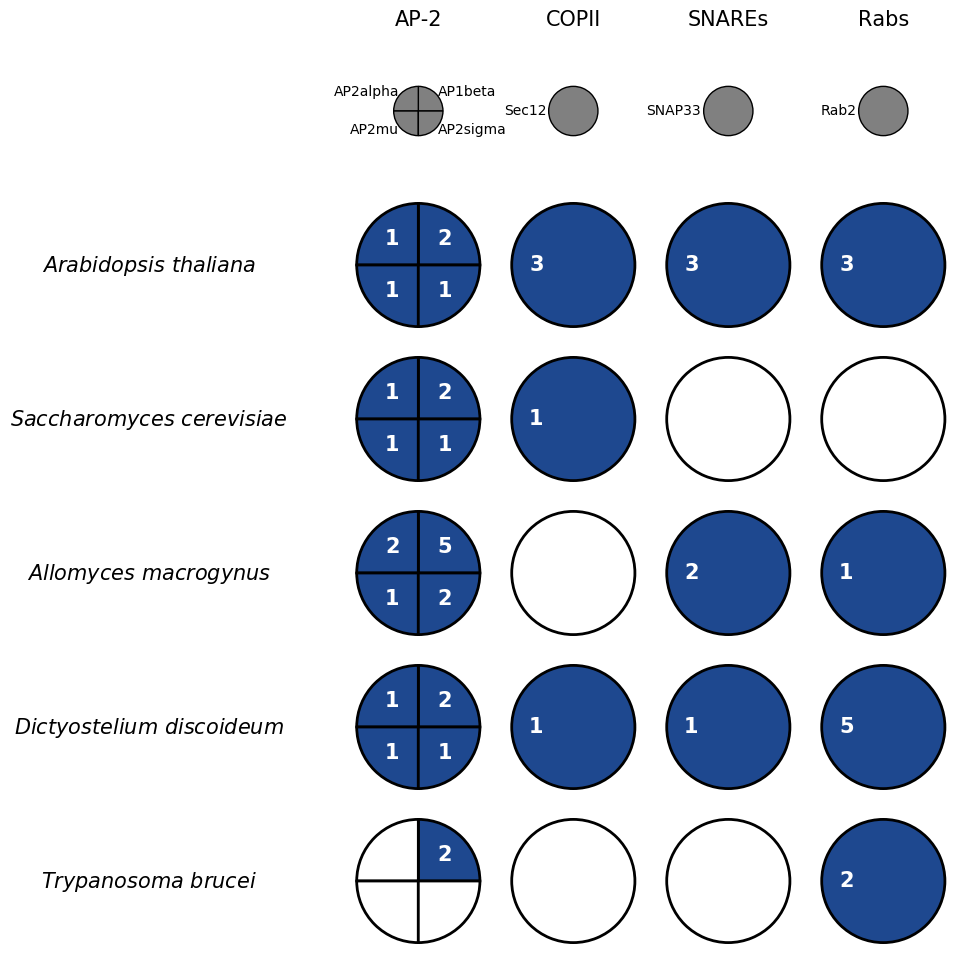

In [58]:
Image(filename=os.path.join(os.environ['SRCHRESDIR'], "plot_coulson_both.png"), width="600px") 

**Figure 1**: A coulson plot summarizing similarity search results for AP-2 complex subunits in *Trypanosoma brucei gambiense* and *Saccharomyces cerevisiae* peptide and nucleotide sequences using *Arabidopsis thaliana* queries and Hidden Markov Models generated from alignments of embryophyte orthologues. BLASTP and TBLASTN were used to search peptide and nucleotide sequences, respectively, with single sequence queries, and the HMMer3 pack- age was used to perform profile searches. Subplot sectors with blue fill indicate that one or more sequences were found to meet the search criteria applied (with the number being indicated within each subplot sector). Note that the ancestral eukaryotic AP-1 and AP-2 complexes shared a single beta subunit (Dacks et al., 2008). This is why identified "AP1beta" orthologues are shown as a component of the AP-2 complex here, even though *T. brucei* lacks an AP-2 complex (Manna et al., 2013). These results are comparable to the relevant results published by Manna et al. (2013), Barlow et al. (2014), and Larson et al. (2019).

# Interpretation and re-analysis

It should be clear that AMOEBAE identifies "positive" and "negative" results simply by applying criteria that the user specifies. So, it is entirely the users responsibility to select appropriate criteria and interpret the results critically.

Points to consider regarding interpretation of the results of the analysis in this tutorial include the following:

- The BLASTP and HMMer searches (both followed by reverse BLASTP searches) yielded the similar results in this analysis.


- The TBLASTN searches were able to identify most of the genes represented by the peptide sequences identified by BLASTP and HMMer searches.


- A TBLASTN hit in the *A. thaliana* chromosome 5 (NC_003076.8) met the forward and reverse search criteria, but was excluded because the translation of the region that aligned to the query was only 50 amino acids long (this sequence also contained stop codons). If you look on the NCBI genome browser for *A. thaliana* you will see that this region on chromosome 5 (as indicated in the summary CSV file) corresponds to a pseudogene for AP-2 sigma with the gene ID AT5G42568.


- The two *A. thaliana* AP-1/2 beta paralogues and the two *S. cerevisiae* paralogues are brassicalid and fungal inparalogues, respectively, which arose from independent gene duplications. Phylogenetic analysis would be required to determine this (see Larson et al. (2019) and Barlow et al. (2014)).


- An *Arabidopsis thaliana* AP-2 mu splice variant was excluded after running the ’find_redun_seqs’ command, because it was found to be encoded by the same gene as the other splice variant based on information in the GFF3 annotation file.


- An *A. thaliana* AP-2 alpha gene was excluded after running the ’find_redun_seqs’ command, because it shows over 98% identity with the other AP-2 alpha gene. The summary CSV file indicates which file contains an alignment of these two sequences (see Larson et al. (2019) for relevant discussion).


- The results for Rab2 illustrate a limitation of the type of reciprocal-best-hit search strategy employed in this tutorial. A positive hit for Rab2 was identified in *Allomyces macrogynus* using these methods. However, Elias et al. (2012) did not identify a Rab2 orthologue *A. macrogynus* in their comprehensive analysis. The positive hit in the analysis herein is a false positive result that occurs due to the absence of Rab4 (a close relative of Rab2) in *A. thaliana*. This example highlights the importance of following up similarity searching with phylogenetic analysis, which compares identified sequences to many homologues simultaneously.

If the analysis in this tutorial were a project you were working on for publication, then upon completing the above analysis steps you work would have only just begun. Careful inspection of the summary CSV file will reveal that minor adjustments to the search criteria would cause the analysis to yield different results. Moreover, there are many different possibilities that would lead to innacurate results based on the criteria applied in the above analysis. A comprehensive discussion of this is beyond the scope of this tutorial. In general, I recommend that you take an iterative approach to analysis involving adjustment of search criteria and re-analysis to include sequences that you know are homologues of interest, but to exclude those that you know are not homologues of interest.

To generate an alignment of homologous sequences identified using AMOEBAE, use the ’csv_to_fasta’ command to generate FASTA files for alignment, and then align using your preferred software (e.g., MUSCLE or MAFFT). For visually assessing the sequences for possible issues such as contrasting domain topologies, you may wish to generate FASTA files including all your forward search results for each query title. If you are planning to run a phylognetic analysis, you may wish to generate a FASTA file with only those sequences that match all your search criteria, and with abbreviated sequence headers the csv_to_fasta comand as follows:

In [59]:
%%bash
CSVLIST=( $SRCHRESDIR/${FWDSRCHDIR}_sum.csv_out_1_interp_*_with_ali_col_paralogue_count_*.csv )

amoebae csv_to_fasta ${CSVLIST[-1]} --abbrev --split_by_query_title


Writing non-redundant sequences to FASTA files.

Output fasta files:
AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825_with_ali_col_paralogue_count_20200412043828_fasta_files/AP1beta_matches.fa
AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825_with_ali_col_paralogue_count_20200412043828_fasta_files/AP2alpha_matches.fa
AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825_with_ali_col_paralogue_count_20200412043828_fasta_files/AP2mu_matches.fa
AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825_with_ali_col_paralogue_count_20200412043828_fasta_files/AP2sigma_matches.fa
AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825_with_ali_col_paralogue_count_20200412043828_fasta_files/Rab2_matches.fa
AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_interp_20200412043825_with_ali_col_paralogue_count_20200412043828_fasta_files/SNAP33_matches.fa
AMOEBAE_Search_Results_1/fwd_srch_1_sum.csv_out_1_in

# Delete search output files (optional)

In [60]:
%%bash
# Delete temporary files.
#rm -r temporary_alignment_dir
#rm -r temporary_db_dir
#rm -r temporary_query_dir

In [61]:
%%bash
# Delete all data and results files (WARNING you may want to keep these!).
#rm -r $DATADIR
#rm -r $SRCHRESDIR
#rm -r $REVSRCHDIR

# Where to go from here?

First, try modifying the parameters and observe how that changes the results. Then customize this notebook to search with different queries in different genomes, or run amoebae from the command line.

# References

Barlow, L.D., Dacks, J.B., Wideman, J.G., 2014. From all to (nearly) none: Tracing adaptin evolution in Fungi. Cellular Logistics 4, e28114. https://doi.org/10.4161/cl.28114

Dacks, J.B., Poon, P.P., Field, M.C., 2008. Phylogeny of endocytic components yields insight into the process of nonendosymbiotic organelle evolution. Proceedings of the National Academy of Sciences 105, 588–593. https://doi.org/10.1073/pnas.0707318105

Elias, M., Brighouse, A., Gabernet-Castello, C., Field, M.C., Dacks, J.B., 2012. Sculpting the endomembrane system in deep time: high resolution phylogenetics of Rab GTPases. Journal of Cell Science 125, 2500–2508. https://doi.org/10.1242/jcs.101378

Hirst, J., D. Barlow, L., Francisco, G.C., Sahlender, D.A., Seaman, M.N.J., Dacks, J.B., Robinson, M.S., 2011. The Fifth Adaptor Protein Complex. PLoS Biology 9, e1001170. https://doi.org/10.1371/journal.pbio.1001170

Larson, R.T., Dacks, J.B., Barlow, L.D., 2019. Recent gene duplications dominate evolutionary dynamics of adaptor protein complex subunits in embryophytes. Traffic 20, 961–973. https://doi.org/10.1111/tra.12698

Manna, P.T., Kelly, S., Field, M.C., 2013. Adaptin evolution in kinetoplastids and emergence of the variant surface glycoprotein coat in African trypanosomatids. Molecular Phylogenetics and Evolution 67, 123–128. https://doi.org/10.1016/j.ympev.2013.01.002

Robinson, M.S., 2004. Adaptable adaptors for coated vesicles. Trends in Cell Biology 14, 167–174. https://doi.org/10.1016/j.tcb.2004.02.002

# Print this notebook

In [62]:
# Define author name for this notebook.
author_name = ""

# Define title of this notebook.
notebook_title = 'amoebae_tutorial_2'.replace('_', ' ')

In [63]:
# Import modules.
import os
from string import Template

# Write a latex template file for converting this notebook to latex (as an intermediate to PDF).
latex_template_string = Template(r"""
((*- extends 'article.tplx' -*))

((* block author *))
\author{$an}
((* endblock author *))

((* block title *))
\title{$nt}
((* endblock title *))
""")
latex_file_contents =\
latex_template_string.substitute(an=author_name,
                                 nt=notebook_title
                                )
latex_template_file_path = 'latex_template.tplx'
with open(latex_template_file_path, 'w') as o:
    o.write(latex_file_contents)

# Convert notebook to PDF (with latex as an intermediate to process bibtex citations, etc.).
!jupyter nbconvert ../amoebae_tutorial_2.ipynb --to pdf --template {latex_template_file_path}

# Remove latex template file and bibtex file.
os.remove(latex_template_file_path)

[NbConvertApp] Converting notebook ../amoebae_tutorial_2.ipynb to pdf
[NbConvertApp] Writing 734458 bytes to ./notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-nbconvert", line 11, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.6/site-packages/jupyter_core/application.py", line 270, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/nbconvert/nbconvertapp.py", line 340, in start
    self.convert_notebooks()
  File "/opt/conda/lib/python3.6/site-packages/nbconvert/nbconvertapp.py", line 510, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/opt/conda/lib/python3.6/site-packages/nbconvert/nbconvertapp.py", line 481, in convert_single_notebook
    output, resources = self.exp